In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# ---------------------------------------------------------
# CONFIG
# ---------------------------------------------------------
results_dir = "/workspace/code/data/LightGBM/results_CV5"        # where your training saved files
analysis_dir =  "/workspace/code/data/LightGBM/analysis_CV5"     # where analysis will be saved
os.makedirs(analysis_dir, exist_ok=True)

n_folds = 5                       # you used 3 outer folds
# ---------------------------------------------------------

metrics_summary = []

for fold in range(1, n_folds+1):
    print(f"\n=== ANALYZING FOLD {fold} ===")

    # ------------------------------
    # Load predictions and Optuna file
    # ------------------------------
    pred_file = f"{results_dir}/fold_{fold}_predictions.csv"
    trials_file = f"{results_dir}/optuna_outer_fold_{fold}.csv"
    fi_file = f"{results_dir}/fold_{fold}_feature_importance.csv"

    df_pred = pd.read_csv(pred_file)
    df_trials = pd.read_csv(trials_file)
    df_fi = pd.read_csv(fi_file)

    # ------------------------------
    # Compute metrics
    # ------------------------------
    mae = np.mean(np.abs(df_pred["pred"] - df_pred["true"]))
    rmse = np.sqrt(np.mean((df_pred["pred"] - df_pred["true"])**2))
    r2 = 1 - np.sum((df_pred["pred"] - df_pred["true"])**2) / np.sum((df_pred["true"] - df_pred["true"].mean())**2)

    metrics_summary.append([fold, mae, rmse, r2])

    print(f"Fold {fold} MAE:  {mae:.4f}")
    print(f"Fold {fold} RMSE: {rmse:.4f}")
    print(f"Fold {fold} R2:   {r2:.4f}")

    # ------------------------------
    # Save metrics table
    # ------------------------------
    df_pred["error"] = df_pred["pred"] - df_pred["true"]

    # Pred vs True Plot
    plt.figure(figsize=(6,6))
    sns.scatterplot(x=df_pred["true"], y=df_pred["pred"], s=20)
    minv, maxv = df_pred["true"].min(), df_pred["true"].max()
    plt.plot([minv, maxv], [minv, maxv], "k--")
    plt.xlabel("True Band Gap")
    plt.ylabel("Predicted Band Gap")
    plt.title(f"Fold {fold}: Predicted vs True")
    plt.tight_layout()
    plt.savefig(f"{analysis_dir}/fold_{fold}_pred_vs_true.png")
    plt.close()

    # Error Histogram
    plt.figure(figsize=(6,4))
    sns.histplot(df_pred["error"], bins=40, kde=True)
    plt.title(f"Fold {fold} Error Distribution")
    plt.xlabel("Prediction Error")
    plt.tight_layout()
    plt.savefig(f"{analysis_dir}/fold_{fold}_error_distribution.png")
    plt.close()

    # Feature Importance
    top_fi = df_fi.sort_values("importance", ascending=False).head(25)
    plt.figure(figsize=(8,6))
    sns.barplot(y="feature", x="importance", data=top_fi)
    plt.title(f"Fold {fold} Top 25 Features")
    plt.tight_layout()
    plt.savefig(f"{analysis_dir}/fold_{fold}_feature_importance.png")
    plt.close()

    # Optuna Trials
    if "value" in df_trials.columns:
        plt.figure(figsize=(6,4))
        sns.scatterplot(x=df_trials.index, y=df_trials["value"])
        plt.xlabel("Trial")
        plt.ylabel("Validation MAE")
        plt.title(f"Fold {fold} Optuna Trial Performance")
        plt.tight_layout()
        plt.savefig(f"{analysis_dir}/fold_{fold}_optuna_trials.png")
        plt.close()

# ---------------------------------------------------------
# SAVE SUMMARY
# ---------------------------------------------------------
df_summary = pd.DataFrame(metrics_summary, columns=["Fold", "MAE", "RMSE", "R2"])
df_summary.to_csv(f"{analysis_dir}/cv_summary.csv", index=False)

print("\n=== ANALYSIS COMPLETE ===")
print(df_summary)
print(f"All plots & tables saved to: {analysis_dir}")



=== ANALYZING FOLD 1 ===
Fold 1 MAE:  0.1417
Fold 1 RMSE: 0.2160
Fold 1 R2:   0.9715

=== ANALYZING FOLD 2 ===
Fold 2 MAE:  0.1408
Fold 2 RMSE: 0.2122
Fold 2 R2:   0.9727

=== ANALYZING FOLD 3 ===
Fold 3 MAE:  0.1411
Fold 3 RMSE: 0.2200
Fold 3 R2:   0.9705

=== ANALYZING FOLD 4 ===
Fold 4 MAE:  0.1430
Fold 4 RMSE: 0.2183
Fold 4 R2:   0.9709

=== ANALYZING FOLD 5 ===
Fold 5 MAE:  0.1423
Fold 5 RMSE: 0.2227
Fold 5 R2:   0.9696

=== ANALYSIS COMPLETE ===
   Fold       MAE      RMSE        R2
0     1  0.141709  0.215952  0.971550
1     2  0.140780  0.212183  0.972677
2     3  0.141101  0.219990  0.970509
3     4  0.142975  0.218335  0.970878
4     5  0.142283  0.222710  0.969602
All plots & tables saved to: /workspace/code/data/LightGBM/analysis_CV5


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

results_path =  "/workspace/code/data/LightGBM/results_CV5/" 

# Load all fold prediction CSVs
pred_files = sorted(glob.glob(results_path + "fold_*_predictions.csv"))
pred_dfs = [pd.read_csv(f) for f in pred_files]

# Load feature importances
fi_files = sorted(glob.glob(results_path + "fold_*_feature_importance.csv"))
fi_dfs = [pd.read_csv(f) for f in fi_files]

# Load Optuna trial histories
optuna_files = sorted(glob.glob(results_path + "optuna_outer_fold_*.csv"))
optuna_dfs = [pd.read_csv(f) for f in optuna_files]

# Combine predictions
df_pred_all = pd.concat(pred_dfs, ignore_index=True)


Fold 1 MAE: 0.1417
Fold 2 MAE: 0.1408
Fold 3 MAE: 0.1411
Fold 4 MAE: 0.1430
Fold 5 MAE: 0.1423

Overall MAE: 0.1417696970483417 ± 0.000793327072761447


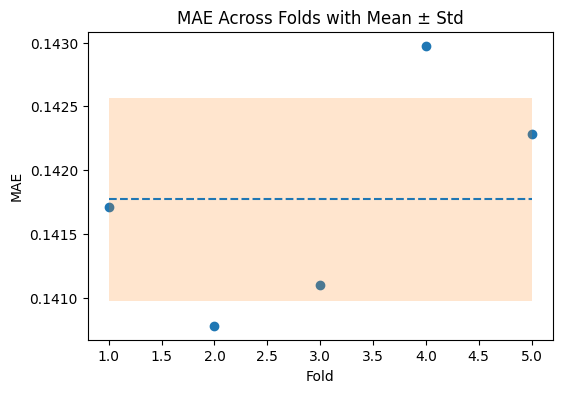

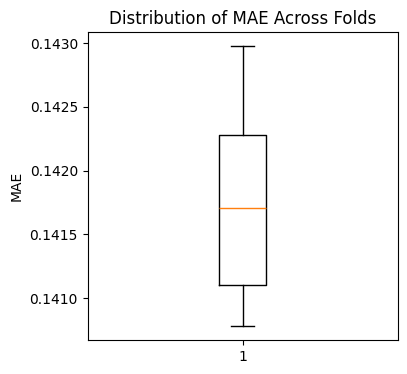

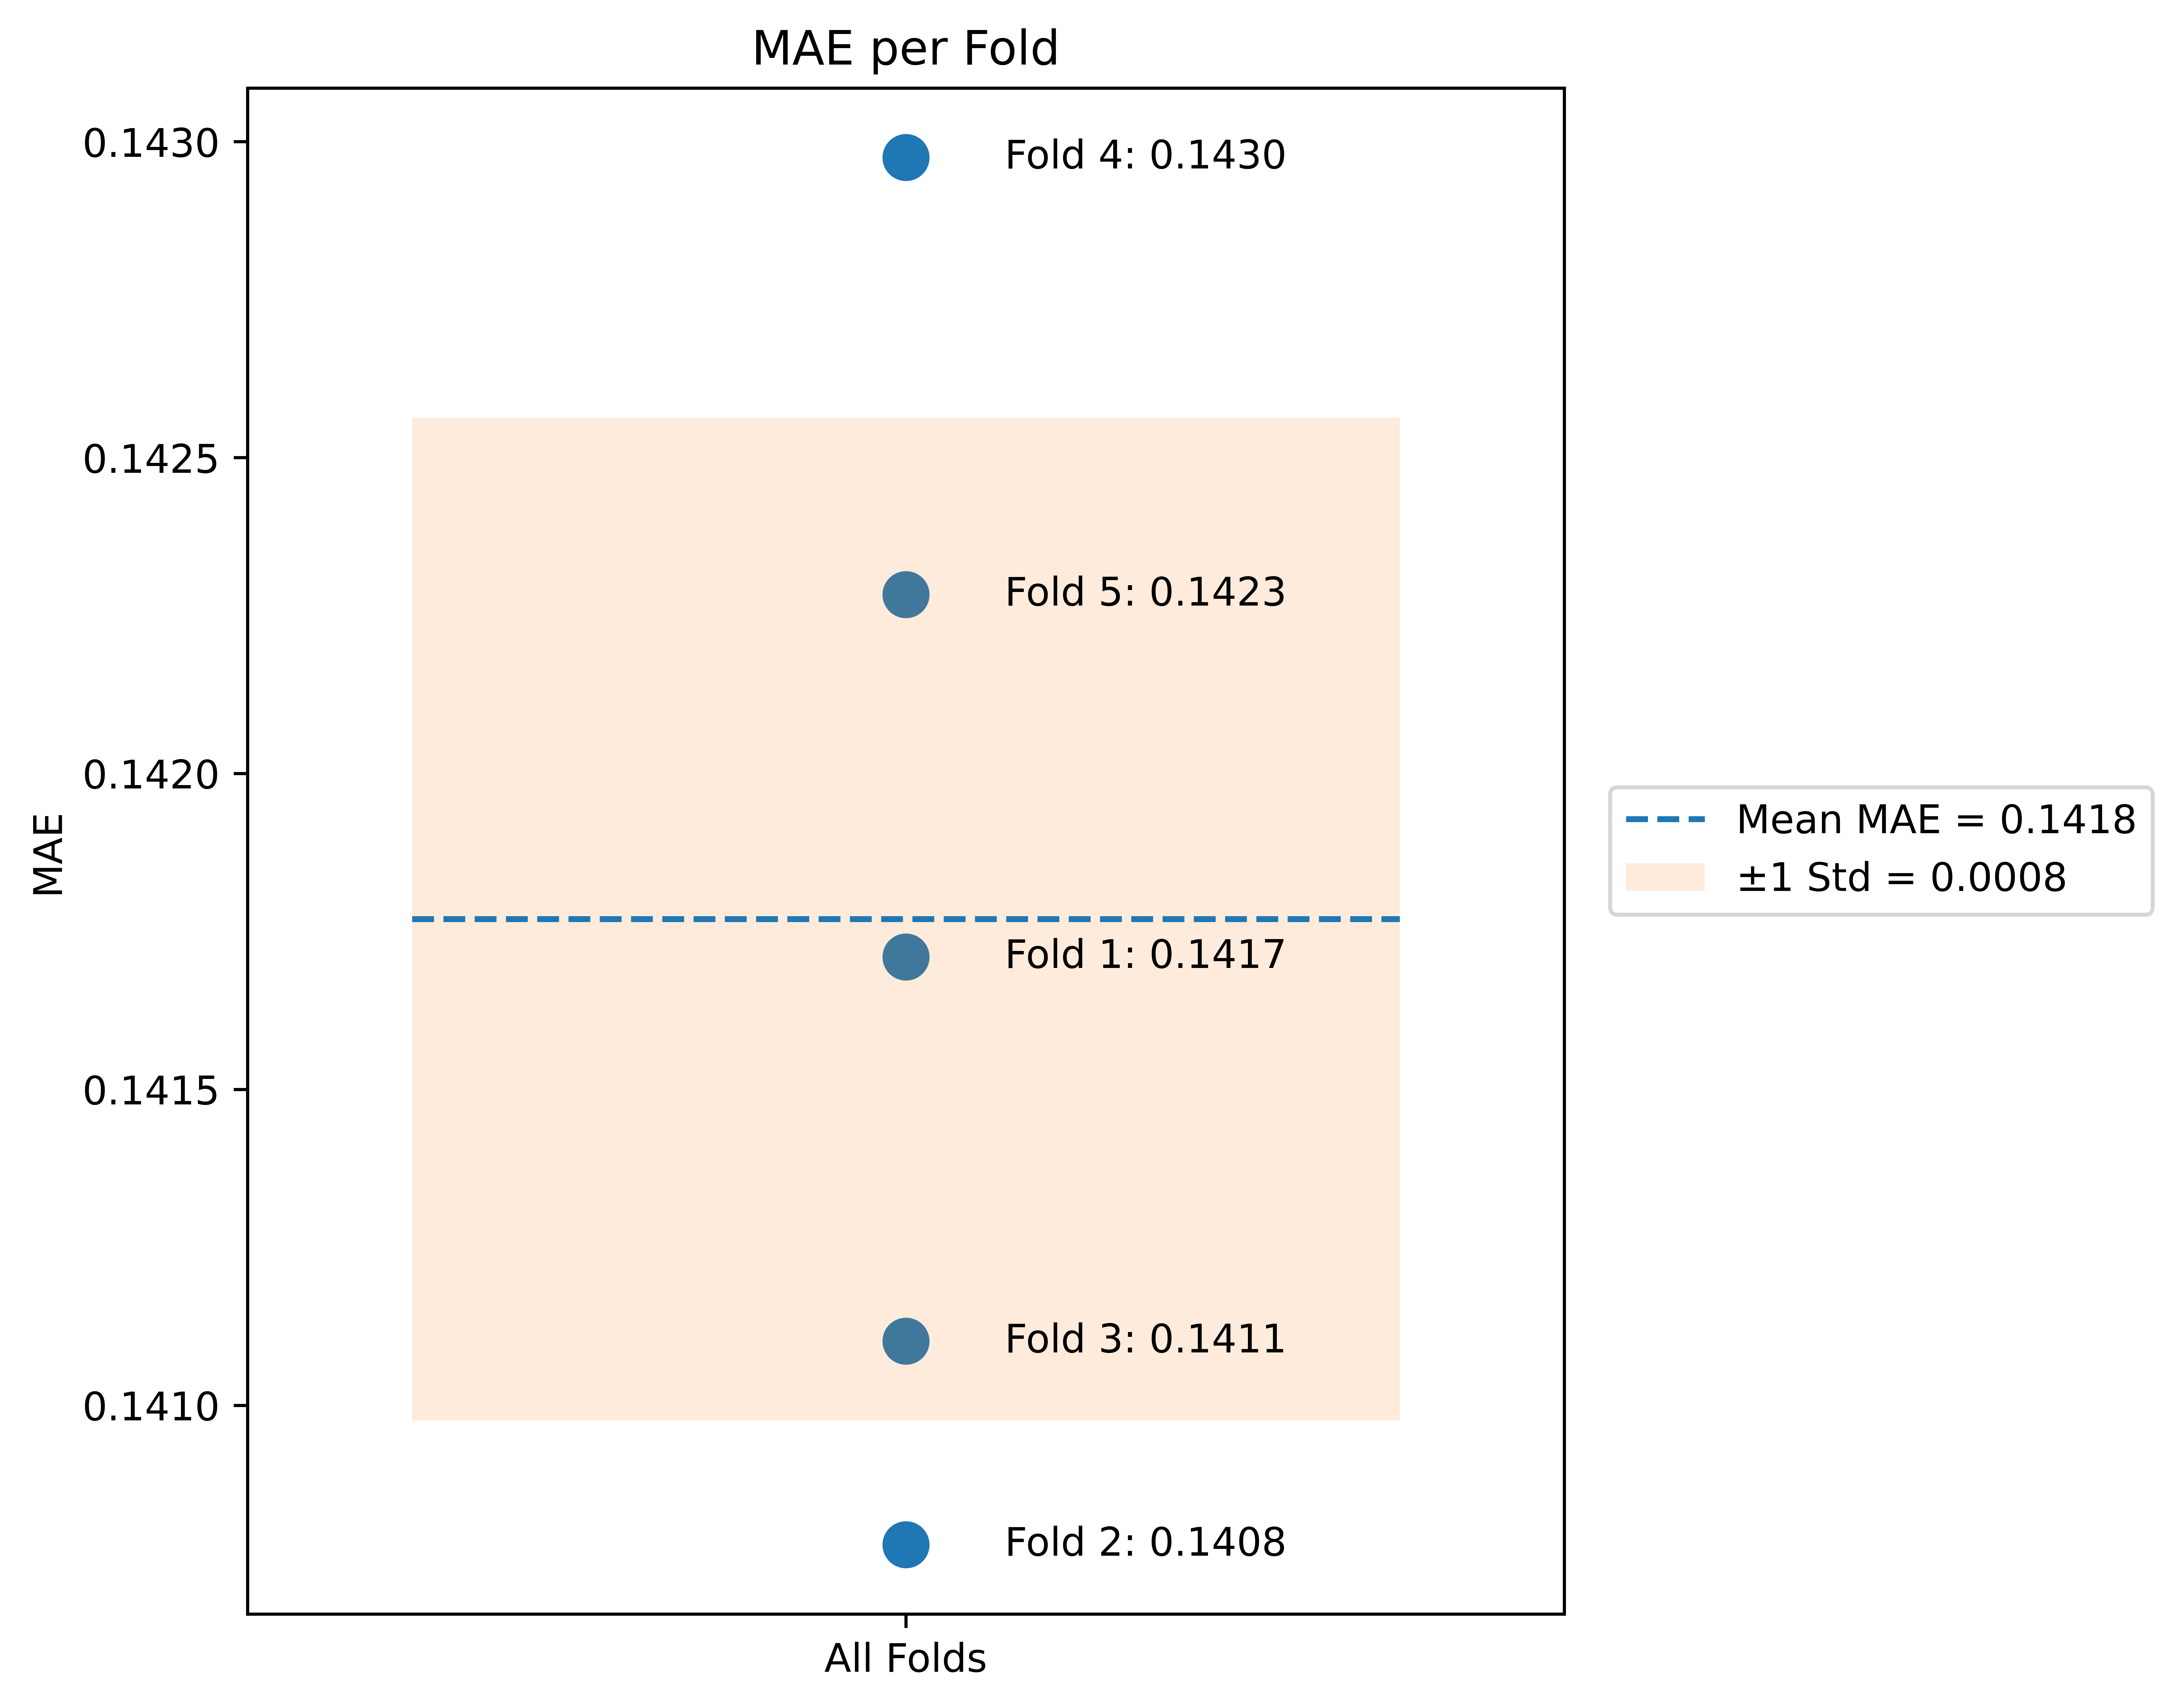

In [12]:
from sklearn.metrics import mean_absolute_error

fold_maes = []
for fold_id, df in enumerate(pred_dfs, start=1):
    mae = mean_absolute_error(df["true"], df["pred"])
    fold_maes.append(mae)
    print(f"Fold {fold_id} MAE: {mae:.4f}")

print("\nOverall MAE:", np.mean(fold_maes), "±", np.std(fold_maes))

import numpy as np

mean_mae = np.mean(fold_maes)
std_mae = np.std(fold_maes)

plt.figure(figsize=(6,4))
plt.scatter(range(1, len(fold_maes)+1), fold_maes)
plt.hlines(mean_mae, 1, len(fold_maes), linestyles="dashed")
plt.fill_between(
    [1, len(fold_maes)],
    mean_mae - std_mae,
    mean_mae + std_mae,
    alpha=0.2
)
plt.xlabel("Fold")
plt.ylabel("MAE")
plt.title("MAE Across Folds with Mean ± Std")
plt.show()
plt.figure(figsize=(4,4))
plt.boxplot(fold_maes)
plt.ylabel("MAE")
plt.title("Distribution of MAE Across Folds")
plt.show()

import matplotlib.pyplot as plt
import numpy as np

# Example: fold_maes = [0.0321, 0.0284, 0.0307, 0.0349, 0.0276]
# Replace with your list
# fold_maes = [...]

mean_mae = np.mean(fold_maes)
std_mae = np.std(fold_maes)

plt.figure(figsize=(6,7), dpi=1000)

# All folds at x = 1
x_pos = np.ones(len(fold_maes))
plt.scatter(x_pos, fold_maes, s=120)

# Add fold labels + exact MAE values
for i, mae in enumerate(fold_maes, start=1):
    plt.text(
        1.03, mae,
        f"Fold {i}: {mae:.4f}",
        va='center'
    )

# Mean line
plt.hlines(mean_mae, 0.85, 1.15, linestyles="dashed", label=f"Mean MAE = {mean_mae:.4f}")

# Std band
plt.fill_between(
    [0.85, 1.15],
    mean_mae - std_mae,
    mean_mae + std_mae,
    alpha=0.15,
    label=f"±1 Std = {std_mae:.4f}"
)

plt.xlim(0.8, 1.2)
plt.xticks([1], ["All Folds"])
plt.ylabel("MAE")
plt.title("MAE per Fold")
plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5))
plt.show()


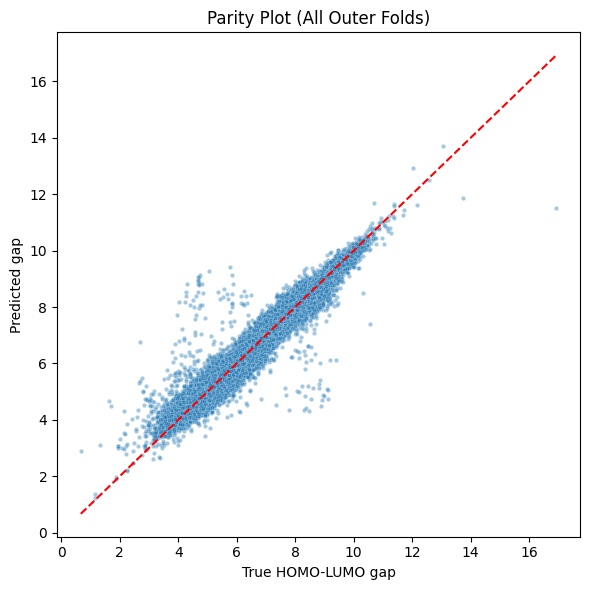

In [6]:
plt.figure(figsize=(6,6))
sns.scatterplot(data=df_pred_all, x="true", y="pred", s=10, alpha=0.4)
plt.plot([df_pred_all["true"].min(), df_pred_all["true"].max()],
         [df_pred_all["true"].min(), df_pred_all["true"].max()],
         color='red', linestyle='--')
plt.xlabel("True HOMO-LUMO gap")
plt.ylabel("Predicted gap")
plt.title("Parity Plot (All Outer Folds)")
plt.tight_layout()
plt.show()


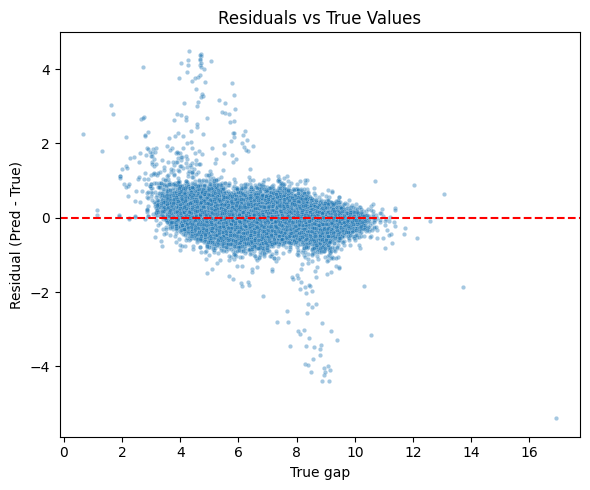

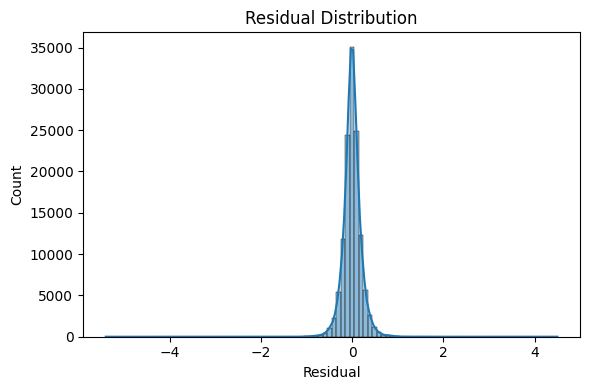

In [8]:
df_pred_all["residual"] = df_pred_all["pred"] - df_pred_all["true"]

plt.figure(figsize=(6,5))
sns.scatterplot(data=df_pred_all, x="true", y="residual", s=10, alpha=0.4)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("True gap")
plt.ylabel("Residual (Pred - True)")
plt.title("Residuals vs True Values")
plt.tight_layout()
plt.show()

# Distribution of Errors
plt.figure(figsize=(6,4))
sns.histplot(df_pred_all["residual"], bins=100, kde=True)
plt.xlabel("Residual")
plt.title("Residual Distribution")
plt.tight_layout()
plt.show()


feature
MinAbsEStateIndex    13939.4
BCUT2D_MWLOW         13526.8
BCUT2D_MRHI          12991.4
BCUT2D_CHGLO         12990.4
AvgIpc               12250.6
BalabanJ             11704.0
BCUT2D_LOGPLOW       11687.2
BCUT2D_MRLOW         10749.2
VSA_EState7          10292.2
MaxPartialCharge     10102.4
MinEStateIndex        9117.6
Ipc                   9078.8
BCUT2D_LOGPHI         8998.6
BertzCT               8824.2
BCUT2D_MWHI           8775.8
MinPartialCharge      8582.2
VSA_EState5           8498.2
qed                   8469.4
PEOE_VSA9             8426.4
BCUT2D_CHGHI          8127.6
Name: importance, dtype: float64


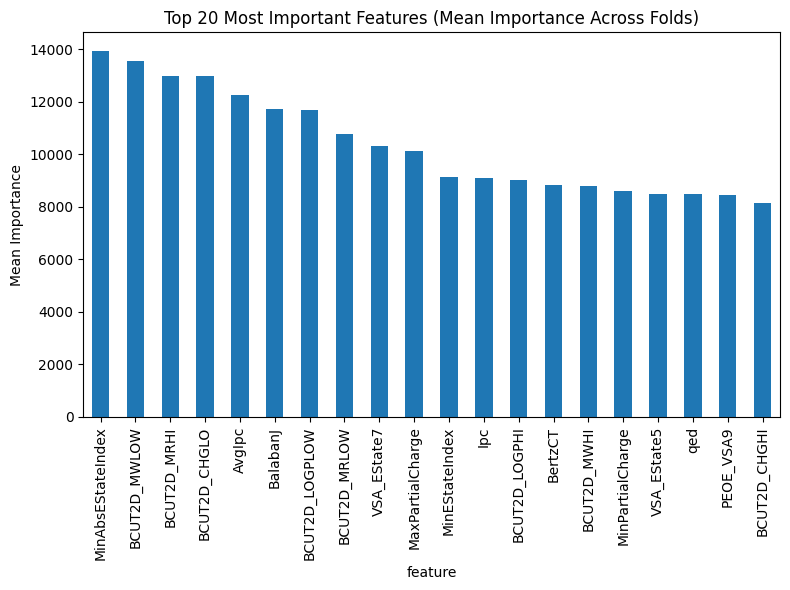

In [11]:
fi_all = pd.concat([
    df.assign(fold=i+1) for i, df in enumerate(fi_dfs)
])

fi_mean = fi_all.groupby("feature")["importance"].mean().sort_values(ascending=False)
print(fi_mean.head(20))
plt.figure(figsize=(8,6))
fi_mean.head(20).plot(kind="bar")
plt.title("Top 20 Most Important Features (Mean Importance Across Folds)")
plt.ylabel("Mean Importance")
plt.tight_layout()
plt.show()


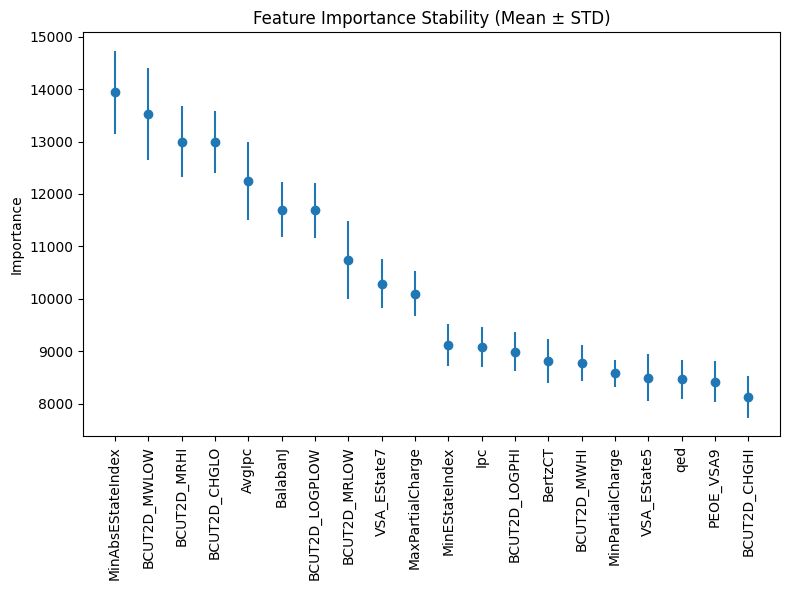

In [12]:
fi_stats = fi_all.groupby("feature")["importance"].agg(["mean", "std"])
fi_stats = fi_stats.sort_values("mean", ascending=False)

# Plot variability
plt.figure(figsize=(8,6))
plt.errorbar(range(20), fi_stats["mean"].head(20), yerr=fi_stats["std"].head(20), fmt='o')
plt.xticks(range(20), fi_stats.head(20).index, rotation=90)
plt.ylabel("Importance")
plt.title("Feature Importance Stability (Mean ± STD)")
plt.tight_layout()
plt.show()


Fold 1: Best MAE = 0.1548
Fold 2: Best MAE = 0.1552
Fold 3: Best MAE = 0.1557
Fold 4: Best MAE = 0.1558
Fold 5: Best MAE = 0.1555


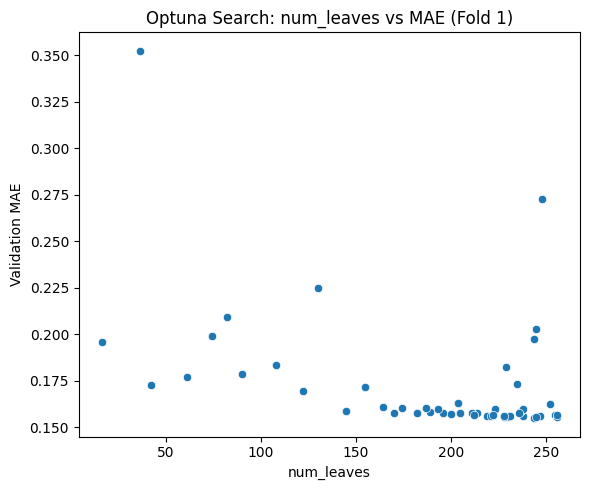

In [13]:
for i, opt_df in enumerate(optuna_dfs, start=1):
    print(f"Fold {i}: Best MAE = {opt_df['value'].min():.4f}")
plt.figure(figsize=(6,5))
sns.scatterplot(data=optuna_dfs[0], x="params_num_leaves", y="value")
plt.xlabel("num_leaves")
plt.ylabel("Validation MAE")
plt.title("Optuna Search: num_leaves vs MAE (Fold 1)")
plt.tight_layout()
plt.show()


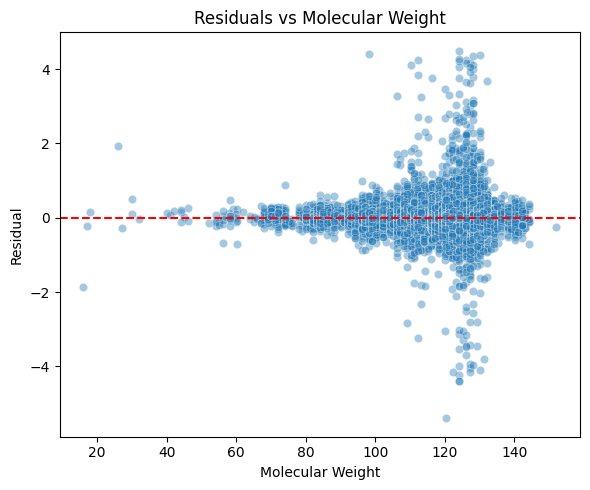

In [16]:
import pandas as pd

df_raw = pd.read_pickle("../data/RDKit/rdkit_only_valid_smiles_qm9.pkl")

X = df_raw.drop(columns=['gaps', 'SMILES'])
y = df_raw['gaps']

df_pred_all_merged = pd.concat([df_pred_all.reset_index(drop=True),
                                X.reset_index(drop=True)], axis=1)

plt.figure(figsize=(6,5))
sns.scatterplot(data=df_pred_all_merged, x="MolWt", y="residual", alpha=0.4)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Molecular Weight")
plt.ylabel("Residual")
plt.title("Residuals vs Molecular Weight")
plt.tight_layout()
plt.show()


Number of outliers (Z-score method, |Z| > 5): 276
             true       pred  fold  residual    z_score
0       13.736308  11.858527     1  1.877781   8.621068
3        6.492637   8.420550     1 -1.927913  -8.847229
3683     4.729339   9.130375     1 -4.401036 -20.198968
4312     3.801430   4.988395     1 -1.186964  -5.446241
4314     2.791888   4.995407     1 -2.203519 -10.112272
...           ...        ...   ...       ...        ...
125388   8.323963   4.862226     5  3.461737  15.891494
126844   2.707533   6.765135     5 -4.057603 -18.622593
127786   4.489879   5.797106     5 -1.307227  -5.998253
127791   3.877622   5.376300     5 -1.498678  -6.877020
128403   3.970141   5.240446     5 -1.270304  -5.828776

[276 rows x 5 columns]
Number of outliers (IQR method): 6124
             true       pred  fold  residual   z_score
0       13.736308  11.858527     1  1.877781  8.621068
3        6.492637   8.420550     1 -1.927913 -8.847229
5        7.768850   8.285348     1 -0.516498 -2.368

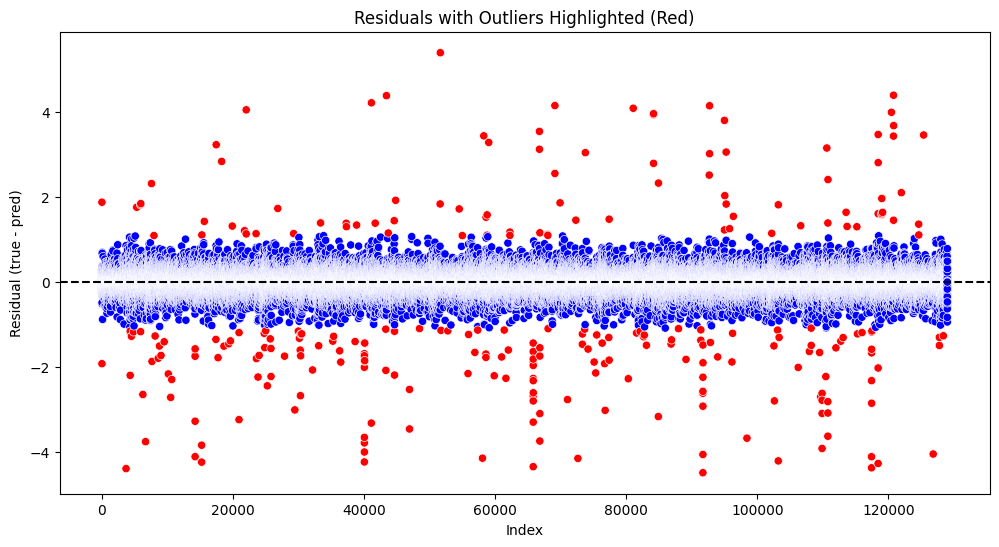

In [27]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# -----------------------------
# Load all fold predictions
# -----------------------------
results_folder = "/workspace/code/data/LightGBM/results_CV5"
pred_files = [f for f in os.listdir(results_folder) if f.startswith("fold_") and f.endswith("_predictions.csv")]

all_preds = pd.concat([pd.read_csv(os.path.join(results_folder, f)) for f in pred_files], ignore_index=True)

# -----------------------------
# Compute residuals
# -----------------------------
all_preds['residual'] = all_preds['true'] - all_preds['pred']

# -----------------------------
# Detect outliers
# Option 1: Z-score method
# -----------------------------
all_preds['z_score'] = zscore(all_preds['residual'])
z_threshold = 5
outliers_z = all_preds[np.abs(all_preds['z_score']) > z_threshold]

print(f"Number of outliers (Z-score method, |Z| > {z_threshold}): {len(outliers_z)}")
print(outliers_z)

# Option 2: IQR method
Q1 = all_preds['residual'].quantile(0.25)
Q3 = all_preds['residual'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = all_preds[(all_preds['residual'] < lower_bound) | (all_preds['residual'] > upper_bound)]
print(f"Number of outliers (IQR method): {len(outliers_iqr)}")
print(outliers_iqr)

# -----------------------------
# Visualize residuals with outliers highlighted
# -----------------------------
plt.figure(figsize=(12,6))
sns.scatterplot(
    x=all_preds.index, 
    y='residual', 
    data=all_preds, 
    hue=(np.abs(all_preds['z_score']) > z_threshold),
    palette={True:'red', False:'blue'},
    legend=False
)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Residual (true - pred)')
plt.title('Residuals with Outliers Highlighted (Red)')
plt.show()


Number of outliers: 138


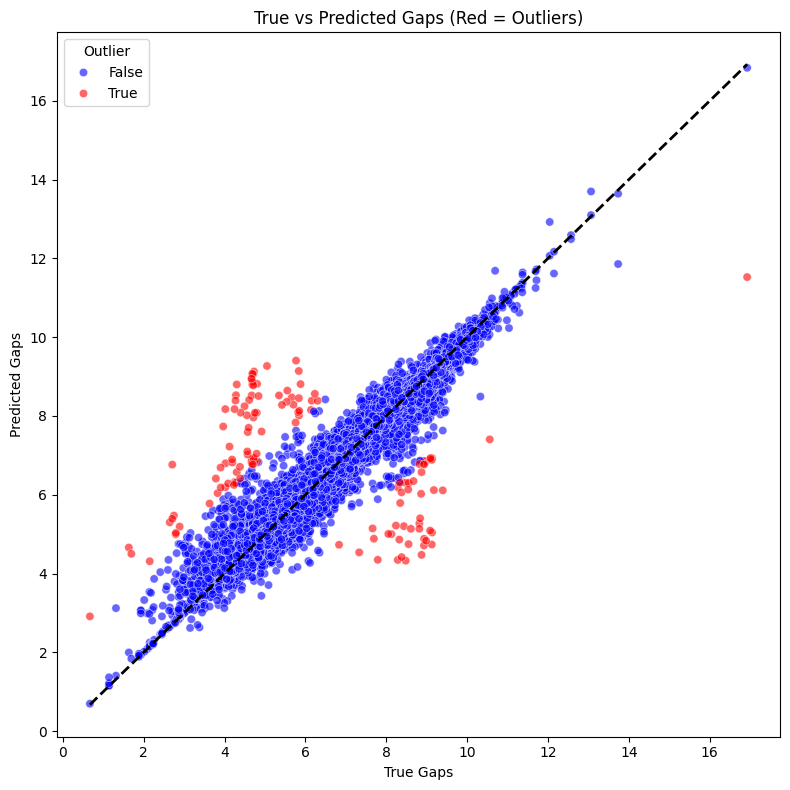

In [37]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------
# Settings
# ------------------------------
results_folder = "/workspace/code/data/LightGBM/results_CV5"
outlier_threshold = 2.0  # MAE difference to consider as outlier

# ------------------------------
# Load all fold predictions
# ------------------------------
all_preds = []
for file in os.listdir(results_folder):
    if file.endswith("_predictions.csv"):
        df_fold = pd.read_csv(os.path.join(results_folder, file))
        all_preds.append(df_fold)

df_preds = pd.concat(all_preds, ignore_index=True)

# ------------------------------
# Identify outliers
# ------------------------------
df_preds['error'] = (df_preds['true'] - df_preds['pred']).abs()
df_preds['is_outlier'] = df_preds['error'] > outlier_threshold

print(f"Number of outliers: {df_preds['is_outlier'].sum()}")

# ------------------------------
# Plot true vs predicted with outliers
# ------------------------------
plt.figure(figsize=(8, 8))
sns.scatterplot(
    x='true', y='pred', 
    hue='is_outlier', 
    palette={True: 'red', False: 'blue'},
    data=df_preds,
    alpha=0.6
)
plt.plot([df_preds['true'].min(), df_preds['true'].max()],
         [df_preds['true'].min(), df_preds['true'].max()],
         'k--', lw=2)
plt.xlabel("True Gaps")
plt.ylabel("Predicted Gaps")
plt.title("True vs Predicted Gaps (Red = Outliers)")
plt.legend(title='Outlier')
plt.tight_layout()
plt.show()
